In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

mtalbert = pd.read_csv('../Data/soil data/AcrossAucklandRainfallStation/MtAlbert_Data_15mins.csv', index_col=['Timestamp (UTC+12:00)'], parse_dates=['Timestamp (UTC+12:00)'])
mtalbert.head()

,Rain(mm),SoilTemp(c),SoilMoisture(%)
Timestamp (UTC+12:00),,,
2018-07-07 11:15:00,0.0,10.4,37.364
2018-07-07 11:30:00,0.0,10.4,37.594
2018-07-07 11:45:00,0.0,10.4,37.590
2018-07-07 12:00:00,0.0,10.5,37.587
2018-07-07 12:15:00,0.0,10.5,37.584


# AR with statsmodels

In [3]:
from statsmodels.tsa.ar_model import AR, ARResults

In [5]:
mtalbert_soil = mtalbert.resample('H').agg({
    'Rain(mm)': 'sum',
    'SoilTemp(c)': 'mean',
    'SoilMoisture(%)': 'mean'
})

C:\Users\Ying\AppData\Local\Temp\ipykernel_3372\1463717319.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  mtalbert_soil = mtalbert.resample('H').agg({


In [7]:
mtalbert.isna().sum()


Rain(mm)           0
SoilTemp(c)        0
SoilMoisture(%)    0
dtype: int64

<Axes: xlabel='Timestamp (UTC+12:00)'>

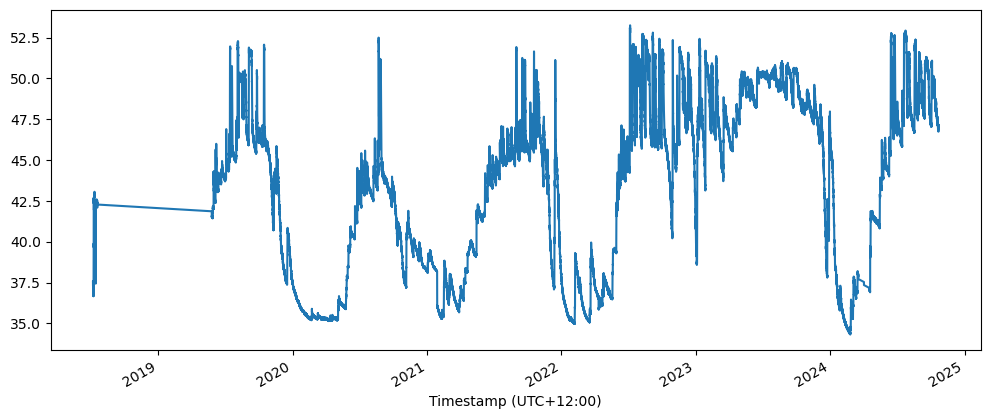

In [8]:
mtalbert['SoilMoisture(%)'].plot(figsize=(12,5))

In [9]:
mtalbert.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187529 entries, 2018-07-07 11:15:00 to 2024-10-21 20:00:00
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Rain(mm)         187529 non-null  float64
 1   SoilTemp(c)      187529 non-null  float64
 2   SoilMoisture(%)  187529 non-null  float64
dtypes: float64(3)
memory usage: 5.7 MB


In [10]:
46589  * 85/100

39600.65

In [11]:
mtalbert.iloc[[39600]]

,Rain(mm),SoilTemp(c),SoilMoisture(%)
Timestamp (UTC+12:00),,,
2020-06-29 22:30:00,0.0,13.9,43.322


In [12]:
# Train test split

train_data = mtalbert.iloc[:39600]
test_data = mtalbert.iloc[39601:]

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
24*28


672

- 24: This corresponds to 1 day (24 hours).
- 72: This corresponds to 3 days (72 hours).
- 168: This corresponds to 7 days (1 week).
- 336: This corresponds to 14 days (2 weeks).
- 504: This corresponds to 21 days (3 weeks).
- 672: This corresponds to 28 days (4 weeks).

In [15]:
print(train_data['SoilMoisture(%)'].isnull().sum())


0


In [16]:
train_data['SoilMoisture(%)'] = train_data['SoilMoisture(%)'].fillna(method='ffill')
train_data = train_data.dropna(subset=['SoilMoisture(%)'])


In [17]:
from statsmodels.tsa.ar_model import AutoReg

ARmodel1 = AutoReg(train_data['SoilMoisture(%)'], lags=[24,72, 168, 336, 504, 672], trend='c')

In [18]:
print(train_data['SoilMoisture(%)'].isnull().sum())


0


In [19]:
AR_fit = ARmodel1.fit()

In [20]:
AR_fit.ar_lags

[24, 72, 168, 336, 504, 672]

In [21]:
mean_soil_moisture = train_data['SoilMoisture(%)'].mean()
print(mean_soil_moisture)

41.10033664562323


In [22]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_data['SoilMoisture(%)'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.24686410949191
p-value: 0.18967802907495446


In [23]:
start = len(train_data)
end = len(train_data) + len(test_data) -1

In [24]:
start

39600

In [25]:
end

187527

In [26]:
predictions1 = AR_fit.predict(start=start, end=end)
print(predictions1)

39600     43.632456
39601     43.628066
39602     43.690925
39603     43.568825
39604     43.675777
            ...    
187523    42.494314
187524    42.494314
187525    42.494314
187526    42.494314
187527    42.494314
Length: 147928, dtype: float64


In [27]:
predictions1 = predictions1.rename('AR1 Predictions')
predictions1

39600     43.632456
39601     43.628066
39602     43.690925
39603     43.568825
39604     43.675777
            ...    
187523    42.494314
187524    42.494314
187525    42.494314
187526    42.494314
187527    42.494314
Name: AR1 Predictions, Length: 147928, dtype: float64

<Axes: xlabel='Timestamp (UTC+12:00)'>

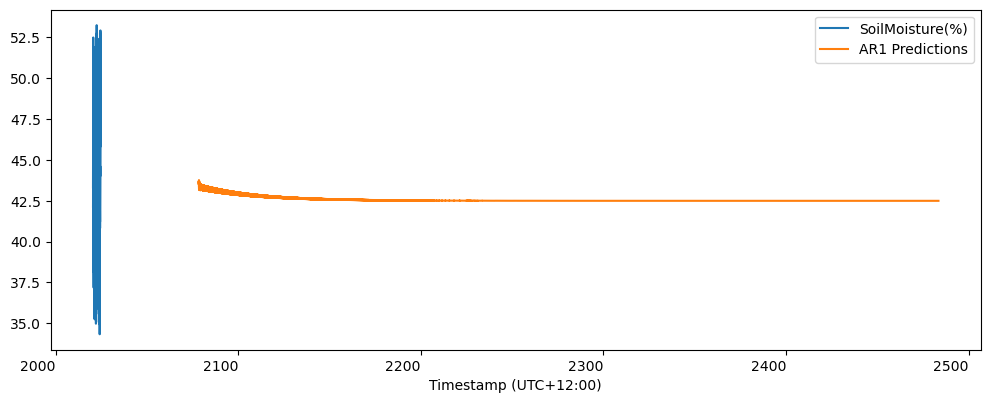

In [28]:
test_data['SoilMoisture(%)'].plot(figsize=(12,5), legend=True)
predictions1.plot(legend=True)

Pmdarima

In [30]:
# mtalbert_day = pd.read_csv('../Data/soil data/mtalbert-648717-20241008172730/MtAlbert_Data_15mins.csv', parse_dates=['Timestamp (UTC+12:00)'])
# mtalbert_day.head()

In [35]:

mtalbert_daily = mtalbert.resample('D').agg({
    'SoilMoisture(%)': 'mean',
    'SoilTemp(c)': 'mean',
    'Rain(mm)': 'sum'
})
mtalbert_daily.head()

,SoilMoisture(%),SoilTemp(c),Rain(mm)
Timestamp (UTC+12:00),,,
2018-07-07,37.337412,11.064706,0.00
2018-07-08,36.910969,11.355208,7.36
2018-07-09,40.972479,12.148958,19.99
2018-07-10,42.747948,11.923958,7.88
2018-07-11,42.727272,11.422581,0.53


In [36]:
mtalbert.head()

,Rain(mm),SoilTemp(c),SoilMoisture(%)
Timestamp (UTC+12:00),,,
2018-07-07 11:15:00,0.0,10.4,37.364
2018-07-07 11:30:00,0.0,10.4,37.594
2018-07-07 11:45:00,0.0,10.4,37.590
2018-07-07 12:00:00,0.0,10.5,37.587
2018-07-07 12:15:00,0.0,10.5,37.584


In [37]:
from pmdarima import auto_arima

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
stepwise_fit= auto_arima(mtalbert['SoilMoisture(%)'], start_p=0, max_p=6, max_q=3, seasonal=False)

In [41]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               187529
Model:               SARIMAX(2, 1, 1)   Log Likelihood              227003.095
Date:                Mon, 04 Nov 2024   AIC                        -453998.190
Time:                        21:57:53   BIC                        -453957.623
Sample:                             0   HQIC                       -453986.217
                             - 187529                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8387      0.002    408.390      0.000       0.835       0.843
ar.L2          0.0855      0.001    125.570      0.000       0.084       0.087
ma.L1         -0.8813      0.002   -443.329      0.000      -0.885      -0.877
sigma2         0.0052   2.15e-06   2420.005      0.000       0.005       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):         264129527.12
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             6.17
Prob(H) (two-sided):                  0.00   Kurtosis:                       186.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
features = len(mtalbert) * 0.8
features

150023.2

In [44]:
train = mtalbert_soil.iloc[:150023]
test = mtalbert_soil.iloc[150023:]

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [49]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

train_data_rain, test_data_rain = train_test_split(mtalbert['Rain(mm)'], test_size=0.3, shuffle=False)
model_rain = ARIMA(train_data_rain, order=(1, 0, 0))
model_fit_rain = model_rain.fit()

# Print AIC and BIC for Rain(mm)
print("AIC for Rain(mm):", model_fit_rain.aic)
print("BIC for Rain(mm):", model_fit_rain.bic)

AIC for Rain(mm): -15419.318914296995
BIC for Rain(mm): -15389.963879647603


In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

forecast_steps = len(test_data_rain)
prediction = model_fit_rain.forecast(steps=forecast_steps)

rmse = sqrt(mean_squared_error(test_data_rain, prediction))

# Calculate MAE
mae = mean_absolute_error(test_data_rain, prediction)

# Calculate MSE
mse = mean_squared_error(test_data_rain, prediction)

# Calculate R2 score
r2 = r2_score(test_data_rain, prediction)

# Print the metrics
print("Airima Root Mean Squared Error (RMSE):", rmse)
print("Airima Mean Absolute Error (MAE):", mae)
print("Airima Mean Squared Error (MSE):", mse)
print("Airima R2 Score:", r2)

Airima Root Mean Squared Error (RMSE): 0.28181564512870744
Airima Mean Absolute Error (MAE): 0.07594853368363824
Airima Mean Squared Error (MSE): 0.07942005783930955
Airima R2 Score: -0.0002153870138537073


In [54]:
y_test_df = pd.DataFrame(model.reset_index(drop=True), columns=['SoilMoisture(%)'])
predictions_df = pd.DataFrame(model, columns=['Predicted'])

results_df = pd.concat([y_test_df, predictions_df], axis=1)

plt.figure(figsize=(5, 3))
sns.scatterplot(x=results_df['SoilMoisture(%)'], y=results_df['Predicted'], color='blue', label='Predicted')
plt.plot([results_df['SoilMoisture(%)'].min(), results_df['SoilMoisture(%)'].max()], 
         [results_df['SoilMoisture(%)'].min(), results_df['SoilMoisture(%)'].max()], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.title('Tomarata Actual vs. Predicted Soil Moisture')
plt.xlabel('Actual Soil Temperature(c)')
plt.ylabel('Predicted Soil Temperature(c)')
plt.legend()
plt.grid()
plt.show()

NameError: name 'model' is not defined